# TAP Thermal Simulations

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.optimize import curve_fit

from gradient import thermal_gradient
from one_zone_analytics import one_zone_analytics

## One zone reactor configurations

In [19]:
gridpoints = 300       

space = np.linspace(0, 0.04, gridpoints)
step_size = space[-1] / (gridpoints - 1)

time = np.linspace(0.0, 1.0, gridpoints)

## One zone temperature gradient

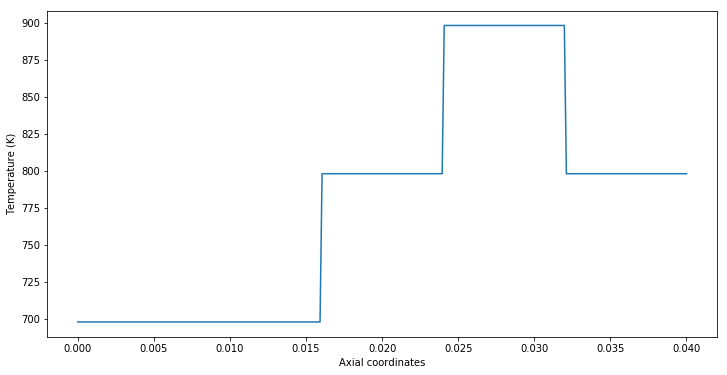

In [18]:
ref_temp = 298.15
temp_measures = [ref_temp + 400, ref_temp + 400, 
                 ref_temp + 500, ref_temp + 600, 
                 ref_temp + 500, ref_temp + 400]

gradient = thermal_gradient(space, temp_measures)

plt.figure(figsize=(12, 6))
plt.plot(space, gradient);
plt.xlabel('Axial coordinates');
plt.ylabel('Temperature (K)');

## One zone diffusion model

In [35]:
def _one_zone_fd(y, time, *args):
    """Converts the one-zone diffusion PDE model to ODE by finite differences."""

    space = np.array(args[0], dtype=float)
    gradient = np.array(args[1], dtype=float)

    ref_coeff, ref_mass, mass = float(args[2]), float(args[3]), float(args[4])
    ref_temp, area, eps =  float(args[4]), float(args[5]), float(args[5])
    
    gridpoints = int(space.size)
    #Solution vector
    dydt = np.zeros(gridpoints)
    # Parameter coefficient
    phi = (step_size ** 2 * eps)
    
    # Reactor inlet
    for index in [1]:
        coeff = knudsen_diffusion_coeff(
            ref_coeff, mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        
        initial_condition = 2 * step_size * boundary_condition(time) / (coeff * area)
        backward = 1 / 3 * (4 * y[index] - y[index + 1] + initial_condition)
        
        dydt[index] = coeff / phi * (y[index + 1] - 2 * y[index] + backward)
    
    # Inner grid
    for index in range(2, gridpoints - 2):
        coeff = knudsen_diffusion_coeff(
            ref_coeff, mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        
        dydt[index] = coeff / phi * (y[index + 1] - 2 * y[index] + y[index - 1])

    # Reactor outlet
    for index in [gridpoints - 2]:
        coeff = knudsen_diffusion_coeff(
            ref_coeff, mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        
        dydt[index] = coeff / phi * (-2 * y[index] + y[index - 1])
        
    return dydt

In [44]:
def _one_zone_numerical(time, ref_coeff):
    """Returns reactor exit flow."""
    
    solu = odeint(
        one_zone_fd, np.zeros(int(space.size)), time, 
        args=(space, gradient, ref_coeff, ref_mass, mass, ref_temp, area, eps)
    )
    
    return solu[:, -2] * ref_coeff * area / (step_size * num_molecules)

In [76]:
# NOTE: Trying out old model
def one_zone_fd(y, time, *args):
    """Converts the one-zone diffusion PDE model to ODE by finite differences."""

    gridpoints, num_mols, tau, Dreff = args[0], args[1], args[2], args[3]
    step, area, T, eps = args[4], args[5], args[6], args[7]
    
    #Solution array
    dydt = np.zeros(gridpoints)

    # Knudsen diffusion coefficient
    coeff = lambda temp: ref_coeff * np.sqrt(temp * ref_mass / ref_temp / mass)

    # Boundary condition
    boundary_cond = lambda time: (num_mols * time / tau ** 2) * np.exp((-1) * (time / tau))

    # Reactor inlet
    for i in [1]:
        initial_condition = 2 * step * boundary_cond(time) / (coeff(T[i]) * area)
        backward = 1 / 3 * (4 * y[i] - y[i + 1] + initial_condition)
        
        dydt[i] = coeff(T[i]) * (y[i + 1] - 2 * y[i] + backward) / step ** 2  / eps

    # Internal grid 
    for i in range(2, gridpoints - 2):
        dydt[i] = coeff(T[i]) * (y[i + 1] - 2*y[i] + y[i - 1]) / step ** 2 / eps

    # Reactor outlet
    for i in [gridpoints - 2]:
        dydt[i] = coeff(T[i]) * (-2*y[i] + y[i-1]) / step ** 2 / eps
    return dydt

In [77]:
# NOTE: Trying out old model
def one_zone_numerical(time, ref_coeff):
    """Returns reactor exit flow."""
    
    solu = odeint(
        one_zone_fd, np.zeros(int(space.size)), time, 
        args=(gridpoints, num_molecules, tau, ref_coeff, step_size, area, gradient, eps)
    )
    
    return solu[:, -2] * ref_coeff * area / (step_size * num_molecules)

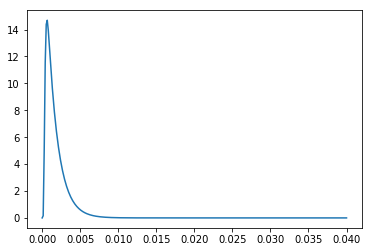

In [78]:
# Parameters
eps = 0.4
tau = 1.e-3
mass = 40.0
ref_mass = 40.0
num_molecules = 1.e-9
area = np.pi * (0.0055) ** 2

ref_coeff = 5.e-3

model = one_zone_numerical(time, ref_coeff)

plt.figure()
plt.plot(space, model)

## Three zone reactor configurations

In [ ]:
# Reactor configuration
zones = [0.016, 0.008, 0.016]
num_gridpoints = 1000

zones_grid = [int(zone_length * num_gridpoints) for zone_length in zones]

time = np.linspace(0.0, 1.0, num_gridpoints)
grid = np.linspace(0.0, sum(zones), sum(axial_grid))

step_size = grid[-1] / (int(grid.size) - 1)




## Three zone temperature gradient

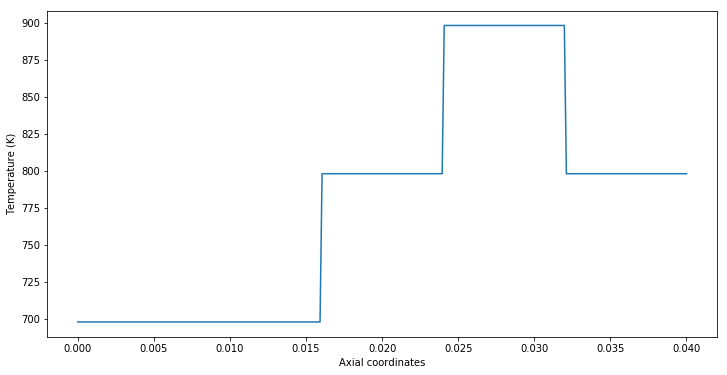

In [42]:
ref_temp = 298.15
temp_measures = [ref_temp + 400, ref_temp + 400, 
                 ref_temp + 500, ref_temp + 600, 
                 ref_temp + 500, ref_temp + 400]

gradient = thermal_gradient(space, temp_measures)

plt.figure(figsize=(12, 6))
plt.plot(space, gradient);
plt.xlabel('Axial coordinates');
plt.ylabel('Temperature (K)');

## Three zone diffusion model

In [ ]:
def three_zone_fd(y, time, *args):
    """Converts the three-zone diffusion PDE model to ODE by finite differences."""
    
    grid, gradient = np.array(args[0], dtype=float), np.array(args[1], dtype=float)
    
    ref_coeffs = np.array(args[2], dtype=float)
    
    ref_mass, mass = float(args[3]), float(args[4])
    ref_temp, area, eps =  float(args[4]), float(args[5]), float(args[6])
    
    dydt = np.zeros(int(grid.size))
    
    num_gridpoints = int(grid.size)
    
    step_size = grid[-1] / (num_gridpoints - 1)

    theta = (eps * step_size ** 2)
    
    ref_coeff = ref_coeffs[0]
    for index in [1]:
        coeff = knudsen_diffusion_coeff(
            ref_coeff, mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        
        initial_condition = 2 * step_size * boundary_condition(time) / (coeff * area)
        backward = 1 / 3 * (4 * y[index] - y[index + 1] + initial_condition)
        
        dydt[index] = coeff / theta * (y[index + 1] - 2 * y[index] + backward)
        
    for index in range(2, zones_grid[0] - 1):
        coeff = knudsen_diffusion_coeff(
            ref_coeff, mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        
        dydt[index] = coeff / theta * (y[index + 1] - 2 * y[index] + y[index - 1])
        
    for index in [zones_grid[0] - 1]:
        coeff = knudsen_diffusion_coeff(
            ref_coeff, mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        
        eta_one = coeff = knudsen_diffusion_coeff(
            ref_coeffs[0], mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        eta_two = coeff = knudsen_diffusion_coeff(
            ref_coeffs[1], mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        
        backward = 4 * eta_one * y[index] - eta_one * y[index - 1]
        forward = 4 * eta_two * y[index + 2] - eta_two * y[index + 3]
        zone_final = (backward + forward) / (3 * eta_one + 3 * eta_two)

        dydt[index] = coeff / theta * (zone_final - 2 * y[index] + y[index - 1])
        
    for index in [zones_grid[0]]:
        coeff = knudsen_diffusion_coeff(
            ref_coeff, mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        
        eta_one = knudsen_diffusion_coeff(
            ref_coeffs[0], mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        eta_two = knudsen_diffusion_coeff(
            ref_coeffs[1], mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        
        backward = 4 * eta_one * y[index - 1] - eta_one * y[index - 2]
        forward = 4 * eta_two * y[index + 1] - eta_two * y[index + 2]
        boundary = (backward + forward) / (3 * eta_one + 3 * eta_two)

        dydt[index] = coeff / theta * (y[index + 1] - 2 * boundary + y[index - 1])
    
    for index in [zones_grid[0] + 1]:
        coeff = knudsen_diffusion_coeff(
            ref_coeff, mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        
        eta_one = knudsen_diffusion_coeff(
            ref_coeffs[0], mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        eta_two = knudsen_diffusion_coeff(
            ref_coeffs[1], mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        
        backward = 4 * eta_one * y[index - 2] - eta_one * y[index - 3]
        forward = 4 * eta_two * y[index + 2] - eta_two * y[index + 3]
        zone_initial = (backward + forward) / (3 * eta_one + 3 * eta_two)

        dydt[index] = coeff / theta * (y[index + 1] - 2 * y[index] + zone_initial)
    
    ref_coeff = ref_coeffs[1]
    for index in range (zones_grid[0] + 2, zones_grid[0] + zones_grid[1] - 1):
        coeff = knudsen_diffusion_coeff(
            ref_coeff, mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        
        dydt[index] = coeff / theta * (y[index + 1] - 2 * y[index] + y[index - 1])
        
    for index in [zones_grid[0] + zones_grid[1] - 1]:
        coeff = knudsen_diffusion_coeff(
            ref_coeff, mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        
        eta_two = knudsen_diffusion_coeff(
            ref_coeffs[1], mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        eta_three = knudsen_diffusion_coeff(
            ref_coeffs[2], mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        
        backward = 4 * eta_two * y[index] - eta_two * y[index - 1]
        forward = 4 * eta_three * y[index + 2] - eta_three * y[index + 3]
        zone_final = (3 * eta_two + 3 * eta_three)

        dydt[index] = coeff / theta * (zone_final - 2 * y[index] + y[index - 1])
    
    for index in [zones_grid[0] + zones_grid[1]]:
        coeff = knudsen_diffusion_coeff(
            ref_coeff, mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        
        eta_two = knudsen_diffusion_coeff(
            ref_coeffs[1], mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        eta_three = knudsen_diffusion_coeff(
            ref_coeffs[2], mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        
        backward = 4 * eta_one * y[index - 1] - eta_one * y[index - 2]
        forward = 4 * eta_two * y[index + 1] - eta_two * y[index + 2]
        boundary = (backward + forward) / (3 * eta_two + 3 * eta_three)

        dydt[index] = coeff / theta * (y[index + 1] - 2 * boundary + y[index - 1])
        
    for index in [zones_grid[0] + zones_grid[1] + 1]:
        coeff = knudsen_diffusion_coeff(
            ref_coeff, mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        
        eta_two = knudsen_diffusion_coeff(
            ref_coeffs[1], mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        eta_three = knudsen_diffusion_coeff(
            ref_coeffs[2], mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        
        backward = 4 * eta_two * y[index - 2] - eta_two * y[index - 3]
        forward = 4 * eta_three * y[index + 2] - eta_three * y[index + 3]
        zone_initial = (backward + forward) / (3 * eta_two + 3 * eta_three)

        dydt[index] = coeff / theta * (y[index + 1] - 2 * y[index] + zone_initial)
        
    ref_coeff = ref_coeffs[2]
    for index in range(zones_grid[0] + zones_grid[1] + 2, sum(zones_grid) - 2):
        coeff = knudsen_diffusion_coeff(
            ref_coeff, mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )
        
        dydt[index] = coeff / theta  * (y[index + 1] - 2 * y[index] + y[index - 1])
    
    for index in [sum(zones_grid) - 2]:
        coeff = knudsen_diffusion_coeff(
            ref_coeff, mass, gradient[index], ref_mass=ref_mass, ref_temp=ref_temp
        )

        dydt[index] = coeff / theta  * (-2 * y[index] + y[index - 1])
        
    return dydt

In [ ]:
def three_zone_numerical(time, ref_coeffs):
    
    initial = np.zeros(int(grid.size))
    
    solu = odeint(three_zone_fd, 
                  np.zeros(int(grid.size)), 
                  time, 
                  args=(grid, 
                        gradient, 
                        ref_coeffs,
                        ref_mass,
                        mass,
                        ref_temp,
                        area,
                        eps))
    
    return solu[:, -2] * ref_coeffs[1] * area / (step_size * num_molecules)

In [ ]:
# Parameters
eps = 0.4
mass = 40.0
ref_mass = 40.0
num_molecules = 1.e-9
area = np.pi * (0.0055) ** 2

ref_coeffs = [5.e-3, 5.e-3, 5.e-3]

model = three_zone_numerical(time, ref_coeffs)